# Combining Tide and Solar Radiation to Model Intertidal Temperatures

The following code notebook is a supplemental document to the paper Ecophysiological Responses to Heat Waves in the Marine Intertidal Zone from the Stillman Lab at San Francisco State University.

It performs a new analysis to predict under-rock intertidal zone thermal maxima based solely on publicly available tidal predictions and solar radiation models.

This code is available at https://github.com/bbukaty/heat-wave-analysis.

To run it, you will need Python 3 and a few scientific computing packages: `h5pyd, pandas, numpy, scipy, and matplotlib`.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats

from utils import *

## Data Sources

### NOAA Tide Predictions
Info from NOAA here: [link](https://tidesandcurrents.noaa.gov/PageHelp.html)

This data source is an API where we can request current and historical tide predictions for sites along the California coast. We request predictions relative to the Mean Low Low Water level (MLLW); see `utils.py` for the full query parameters to this API.

### NSRDB Physical Solar Model 3
Info from NSRDB here: [link](https://nsrdb.nrel.gov/data-sets/us-data)
> The National Solar Radiation Database (NSRDB) is a serially complete collection of hourly and half-hourly values of meteorological data and the three most common measurements of solar radiation: global horizontal, direct normal and diffuse horizontal irradiance.
> It covers the United States and a growing subset of international locations. These data have been collected at a sufficient number of locations and temporal and spatial scales to accurately represent regional solar radiation climates. For a given location covered by the dataset, it is possible to see the amount of solar energy that was at a given time, and to predict the potential future availability of solar energy based on past conditions.





## Load NSRDB GHI Data

First, we load some hardcoded information about our Fort Ross site, where we have access to logged intertidal temperature data <citation>.  
See [01_yearly_ghi.ipynb](01_yearly_ghi.ipynb) for how the closest NSRDB site was calculated; NOAA station ID was selected from their [website](https://tidesandcurrents.noaa.gov/tide_predictions.html) manually.

In [2]:
site = SITES['Fort Ross']
site

{'name': 'Fort Ross',
 'tz': 'America/Los_Angeles',
 'loc': (38.51265, -123.24647),
 'noaa_station_id': 9416024,
 'nsrdb_site_id': 131123}

Next we load NSRDB GHI data for 2015 and 2016, the years with the logged temperature data.  
Note that this NSRDB data was formatted with UTC timestamps, so care was taken to localize those to Fort Ross's pacific time zone.  


`get_nsrdb_data` also caches data in `/cached` to reduce queries to the NSRDB API.

In [3]:
ghi_2015 = get_nsrdb_data(2015, 'ghi', site['nsrdb_site_id'], site['tz'])
ghi_2016 = get_nsrdb_data(2016, 'ghi', site['nsrdb_site_id'], site['tz'])
ghi_extended = pd.concat([ghi_2015, ghi_2016])
ghi_extended.head()

Found cached/site-131123-data-2015.pkl, loading...
Found cached/site-131123-data-2016.pkl, loading...


2014-12-31 16:00:00-08:00    135
2014-12-31 16:30:00-08:00     57
2014-12-31 17:00:00-08:00      0
2014-12-31 17:30:00-08:00      0
2014-12-31 18:00:00-08:00      0
dtype: int16

## Load Logged Temperature Data
The data includes two sets of temperature loggers, at high and low intertidal elevation. We use the high loggers for our analysis.

In [4]:
hot_rocks_df = get_hot_rocks_data()

# apply boolean mask to get high elevation data, then select the temperature series specifically
year_temps_high = hot_rocks_df[hot_rocks_df['elev'] == 'high']['temp']
year_temps_high.head()

dt
2015-06-19 00:02:00-07:00    11.0
2015-06-19 00:04:00-07:00    11.0
2015-06-19 00:05:00-07:00    10.5
2015-06-19 00:05:00-07:00    11.0
2015-06-19 00:07:00-07:00    11.0
Name: temp, dtype: float64

## Get NOAA Tide Predictions via API

The requested time period includes one day of padding on each end; this is for the interpolation that we describe below.

In [5]:
both_years_padded = [get_year_padded(2015)[0], get_year_padded(2016)[1]]
print(both_years_padded)
tide_series = get_noaa_tide_preds(site, both_years_padded)

['20141231', '20170101']


### Tide Interpolation

The data we get from NOAA will be daily predicted high and low tide values. To compare and combine the tide level and the higher resolution GHI data, we interpolate the water level between the high and low predicted tides with cubic interpolation.

<Axes: title={'center': 'Interpolated Tide Predictions, Visualized'}, xlabel='t'>

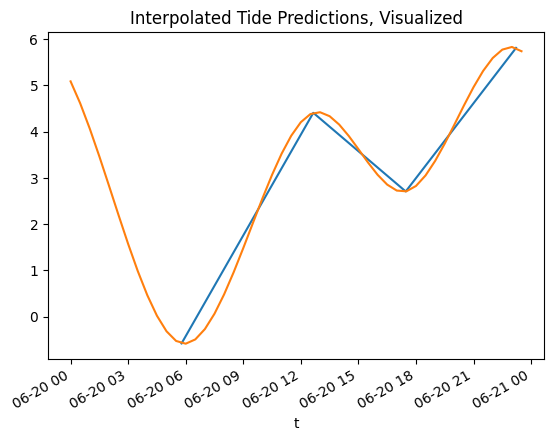

In [6]:
# Interpolate tide high/low data to get a tide value for every timestamp in the ghi data series
tide_high_res = interpolate_tide_preds(tide_series, ghi_extended.index)

EXAMPLE_DATE = '2016-06-20'
tide_series[EXAMPLE_DATE].plot()
tide_high_res[EXAMPLE_DATE].plot(title="Interpolated Tide Predictions, Visualized")

## Visualizing Data Sources
Below we create a plot of all three of our data sources for one week in 2016. GHI is shown in red, predicted tide level in blue, and logged temperature in orange.

In [7]:
week_start, week_end = '2016-06-09', '2016-06-16'
example_week_ghi = ghi_extended[week_start:week_end]
example_week_temps = year_temps_high[week_start:week_end]
example_week_tides = tide_high_res[week_start:week_end]

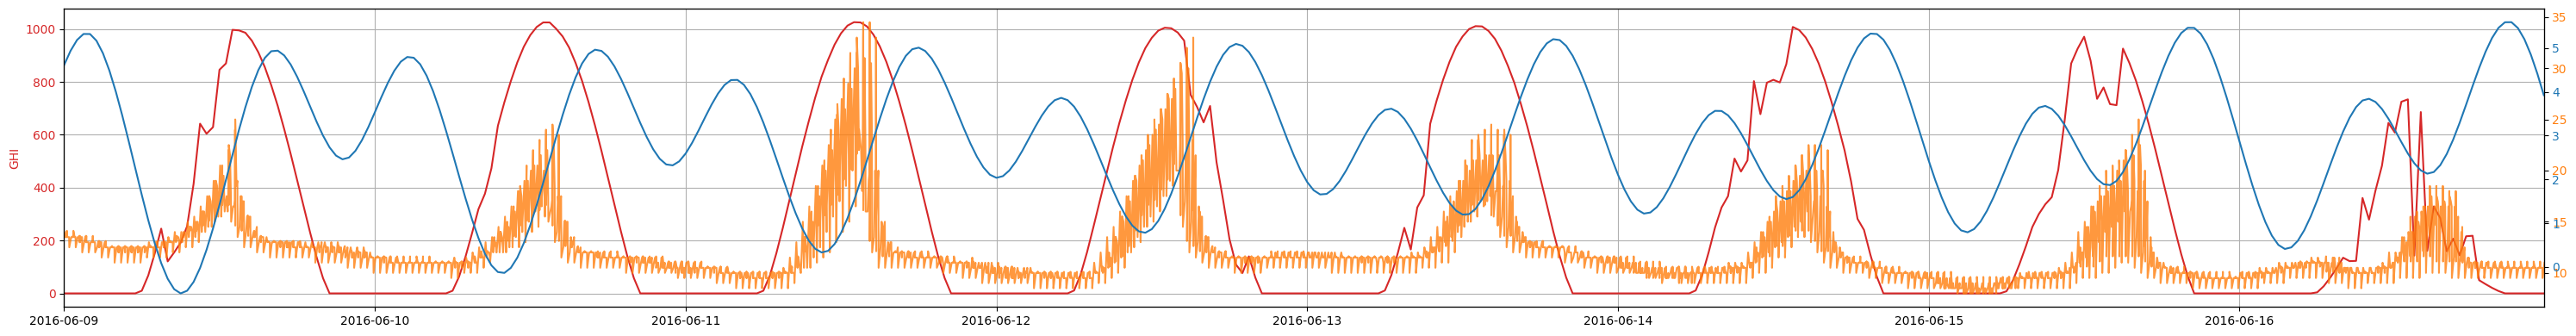

In [8]:
fig, ax1 = plt.subplots(figsize=(30, 4))

# Plot GHI data
ax1.plot(example_week_ghi.index, example_week_ghi, label='GHI', color='tab:red')
ax1.xaxis.set_major_locator(mdates.DayLocator(tz=site['tz']))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=site['tz']))
plt.xlim(example_week_ghi.index[0], example_week_ghi.index[-1])
ax1.set_ylabel('GHI', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.plot(example_week_temps.index, example_week_temps, label='Low Tide Water Temp', color='tab:orange', alpha=0.8)
ax2.tick_params(axis='y', labelcolor='tab:orange')

ax3 = ax1.twinx()
ax3.plot(example_week_tides.index, example_week_tides, label='Tide', color='tab:blue')
ax3.tick_params(axis='y', labelcolor='tab:blue')

ax1.grid(True)

fig.tight_layout()
plt.show()


## Calculate Tide-Scaled GHI
To model the intuition that less solar radiation reaches the mid and low intertidal during periods of high tide, the next step is to scale the timestamped GHI data with the corresponding tide level.

First we normalize the tide data to a 0-1 range, where 0 is the lowest tide recorded over the period of logged temperatures and 1 is the highest. Then we invert that value by subtracting it from 1, so that we multiply by 0 when the tide is high and 1 when tide is low.

In [9]:
# Normalize tide data to a 0-1 scale based on highest and lowest observed values over hot rocks data collection period
min_val, max_val = tide_high_res.min(), tide_high_res.max()
tide_values_normalized = (tide_high_res - min_val) / (max_val - min_val)

# Then invert the values so 1 is low tide, 0 is high tide
tide_values_inverted = 1 - tide_values_normalized

# Confirm we didn't mess up the data shape, before we try to multiply
assert tide_values_inverted.shape == ghi_extended.shape
tide_scaled_ghi = tide_values_inverted * ghi_extended

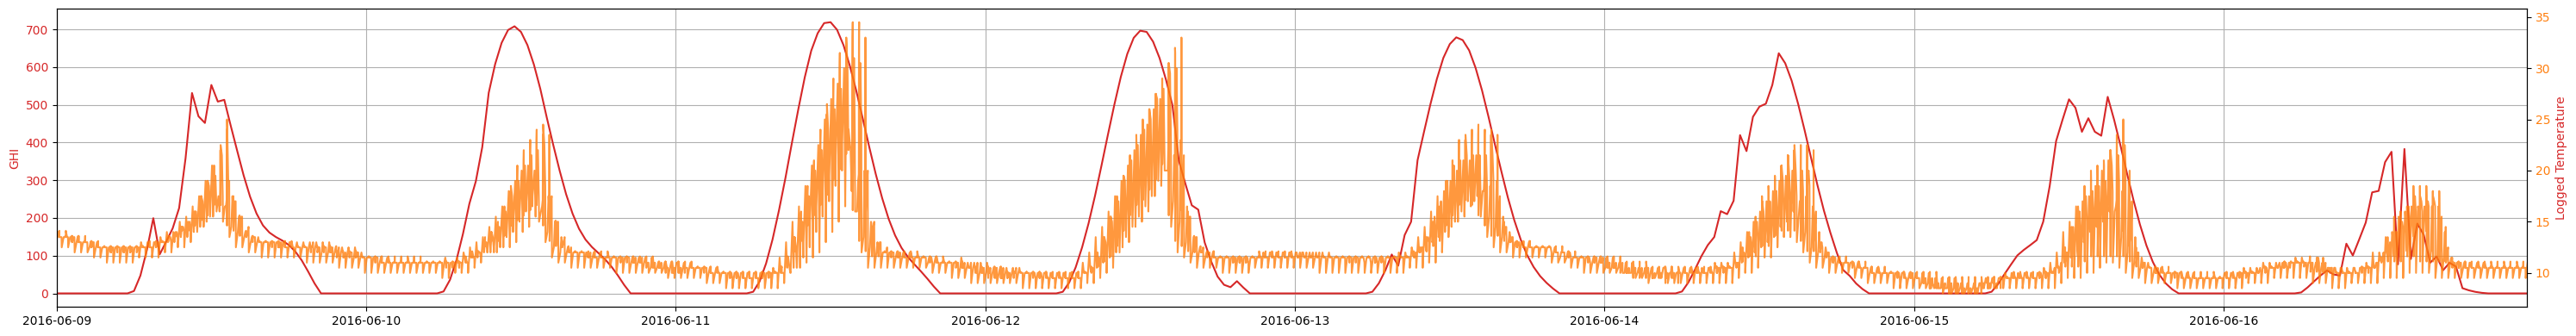

In [10]:
example_week_scaled_ghi = tide_scaled_ghi[week_start:week_end]

fig, ax1 = plt.subplots(figsize=(30, 4))

ax1.plot(example_week_scaled_ghi.index, example_week_scaled_ghi, label='GHI', color='tab:red')
ax1.xaxis.set_major_locator(mdates.DayLocator(tz=site['tz']))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=site['tz']))
plt.xlim(example_week_scaled_ghi.index[0], example_week_scaled_ghi.index[-1])
ax1.set_ylabel('GHI', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.plot(example_week_temps.index, example_week_temps, label='Low Tide Water Temp', color='tab:orange', alpha=0.8)
ax2.set_ylabel('Logged Temperature', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:orange')

ax1.grid(True)

fig.tight_layout()
plt.show()


## Examine Model/Data Correlation

Next we'll be focusing on the daily maximum tide-scaled GHI and the daily maximum recorded temperature; we calculate those below then perform a regression analysis across the days of recorded data.

In [11]:
# Resample logged temperature data and tide-scaled ghi data to daily maximum values
max_scaled_ghi = tide_scaled_ghi.resample('D').max()
max_recorded_temp = year_temps_high.resample('D').max()

# Confirm timezones are the same before we merge data into one frame
assert max_recorded_temp.index.tz == max_scaled_ghi.index.tz
df = pd.concat([max_scaled_ghi, max_recorded_temp], axis=1)
df.columns = ['max_scaled_ghi', 'max_recorded_temp']

# Drop rows where any of the values is NaN (this should only be days where there's no hot rocks data)
df = df.dropna()

In [12]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['max_scaled_ghi'], df['max_recorded_temp'])

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")

Slope: 0.027602904496784517
Intercept: 9.786316316414487
R-squared: 0.6861106634741813
P-value: 8.291743650502403e-117
Standard error: 0.000874306199613332


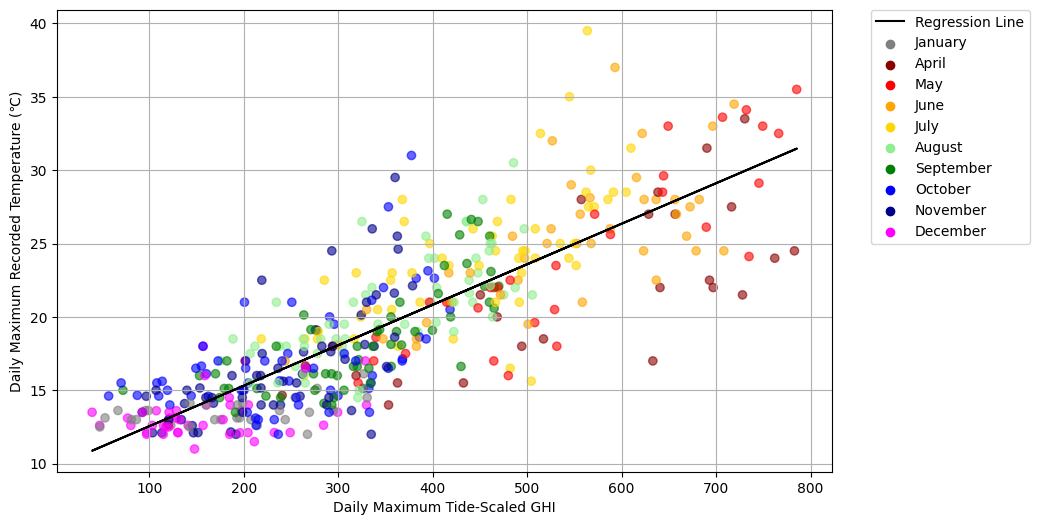

In [13]:
# Map the colors to the entries in the frame
colors = df.index.month.map(lambda x: MONTH_COLORS[x])

# Create a scatter plot with specific month colors
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['max_scaled_ghi'], df['max_recorded_temp'], color=colors, alpha=0.6)

# Add regression line
x = df['max_scaled_ghi']
y = intercept + slope * x
plt.plot(x, y, color='black', label='Regression Line')  # Use a neutral color for the line

# Add invisible points for creating the legend for months
for month, color in MONTH_COLORS.items():
    plt.scatter([], [], color=color, label=pd.to_datetime(month, format='%m').month_name())

plt.xlabel('Daily Maximum Tide-Scaled GHI')
plt.ylabel('Daily Maximum Recorded Temperature (℃)')
plt.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()